# XXXXXXXX

In [1]:
!git clone https://github.com/Kazuhito00/7-segment-display-reader

Cloning into '7-segment-display-reader'...
remote: Enumerating objects: 21908, done.
remote: Counting objects: 100% (21908/21908), done.
remote: Compressing objects: 100% (21889/21889), done.
remote: Total 21908 (delta 39), reused 21869 (delta 16), pack-reused 0
Receiving objects: 100% (21908/21908), 62.92 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Checking out files: 100% (42000/42000), done.


# XXXXXXXX

In [2]:
!git clone https://github.com/Kazuhito00/7seg-image-generator.git

Cloning into '7seg-image-generator'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 45 (delta 21), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [3]:
!python '7seg-image-generator/create_7segment_dataset_da(easy).py' \
    --erase_debug_window \
    --steps=4000 \
    --start_count=10000000

100% 4000/4000 [00:37<00:00, 107.80it/s]


# XXXXXXXX

In [4]:
%cp -rf './7-segment-display-reader/01.dataset/00' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/01' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/02' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/03' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/04' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/05' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/06' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/07' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/08' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/09' './dataset'
%cp -rf './7-segment-display-reader/01.dataset/11' './dataset'

# XXXXXXXX

In [5]:
import os

dataset_directory = './dataset'
train_directory = './train'
validation_directory = './validation'

# 学習データ格納ディレクトリ作成　※「dataset_directory」と同様の構成
for dir_path in os.listdir(dataset_directory):
    os.makedirs(train_directory + '/' + dir_path, exist_ok=True)
# 検証データ格納ディレクトリ作成　※「dataset_directory」と同様の構成
for dir_path in os.listdir(dataset_directory):
    os.makedirs(validation_directory + '/' + dir_path, exist_ok=True)

In [6]:
import os
import random

import numpy as np
import tensorflow as tf

seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
import glob
import shutil
import random

train_ratio = 0.75  # 学習データの割合

random.seed(42)

# コピー元ディレクトリ取得
directory_list = glob.glob(dataset_directory + '/*')
for temp_directory in directory_list:
    file_list = glob.glob(temp_directory + '/*')

    # ディレクトリへコピー
    for index, filepath in enumerate(file_list):
        if index < int(len(file_list) * train_ratio):
            # 学習用データ
            shutil.copy2(filepath, train_directory + '/' + os.path.basename(temp_directory))
        else:
            # 検証用データ
            shutil.copy2(filepath, validation_directory + '/' + os.path.basename(temp_directory))

# XXXXXXX

In [8]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 47.6 MB 49 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [9]:
# Albumentationsを用いたデータ拡張設定
import albumentations as A

def preprocessing_augmentation_function(param_p = 0.0):
    transform = [
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.1, 
                           rotate_limit=10,
                           p=param_p),
        A.MotionBlur(blur_limit=15, p=param_p),
        A.GlassBlur(sigma=0.15, max_delta=4, iterations=1, p=param_p),
        A.RandomBrightnessContrast(brightness_limit=0.2,
                                   contrast_limit=0.2,
                                   brightness_by_max=True,
                                   p=param_p),
        A.RGBShift(r_shift_limit=10,
                   g_shift_limit=10,
                   b_shift_limit=10,
                   p=param_p),
        A.Cutout(num_holes=8,
                 max_h_size=8,
                 max_w_size=8,
                 fill_value=0,
                 p=param_p),
        A.Cutout(num_holes=8,
                 max_h_size=8,
                 max_w_size=8,
                 fill_value=255,
                 p=param_p),
    ]
    augmentation_function = A.Compose(transform)

    def augmentation(x):
        augmentation_image = augmentation_function(image=x)
        return augmentation_image['image']

    return augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_da_generator = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocessing_augmentation_function(0.1),
)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [11]:
batch_size = 64
image_height, image_width = 96, 96

train_data_gen = train_image_da_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_directory,
    shuffle=True,
    target_size=(image_height, image_width),
    class_mode='categorical'
)
validation_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_directory,
    shuffle=False,
    target_size=(image_height, image_width),
    class_mode='categorical'
)

Found 67490 images belonging to 12 classes.
Found 22500 images belonging to 12 classes.


In [12]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3), alpha=0.35)

base_model.trainable = True

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(12, activation='softmax', name='last_output')(x)
model = tf.keras.Model(inputs=base_model.inputs, outputs=output, name='model')

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

2031616/2019640 [==============================] - 0s 0us/step


In [13]:
# モデルチェックポイント保存用コールバック
checkpoint_path = os.path.join(os.getcwd(), 'checkpoints', 'weights.hdf5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, 
    verbose=1, 
    save_best_only=True,
    mode='auto',
    save_weights_only=False, 
    save_freq='epoch'
)

# 評価値の改善が見られない場合に学習率を減らすコールバック
lrp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1) 

In [14]:
epochs = 100

history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=validation_data_gen,
    callbacks=[cp_callback, lrp_callback, es_callback]
)

Epoch 1/100
1055/1055 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.7472
Epoch 00001: val_loss improved from inf to 1.44679, saving model to /content/checkpoints/weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1055/1055 [==============================] - 107s 83ms/step - loss: 0.7381 - accuracy: 0.7472 - val_loss: 1.4468 - val_accuracy: 0.6114 - lr: 0.0100
Epoch 2/100
1055/1055 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8116
Epoch 00002: val_loss improved from 1.44679 to 0.10920, saving model to /content/checkpoints/weights.hdf5
1055/1055 [==============================] - 86s 82ms/step - loss: 0.5236 - accuracy: 0.8116 - val_loss: 0.1092 - val_accuracy: 0.9697 - lr: 0.0100
Epoch 3/100
1055/1055 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.8132
Epoch 00003: val_loss improved from 0.10920 to 0.02139, saving model to /content/checkpoints/weights.hdf5
1055/1055 [==============================] - 87s 83ms/step - loss: 0.5145 - accuracy: 0.8132 - val_loss: 0.0214 - val_accuracy: 0.9936 - lr: 0.0100
Epoch 4/100
1055/1055 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8170
Epoch 00004: val_loss did not improve from 0.0

# XXXXXXXX

In [15]:
evaluate_result = model.evaluate_generator(validation_data_gen)
print('Validation Loss:' + str(evaluate_result[0]))
print('Validation Accuracy:' + str(evaluate_result[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Validation Loss:0.011064750142395496
Validation Accuracy:0.9968888759613037


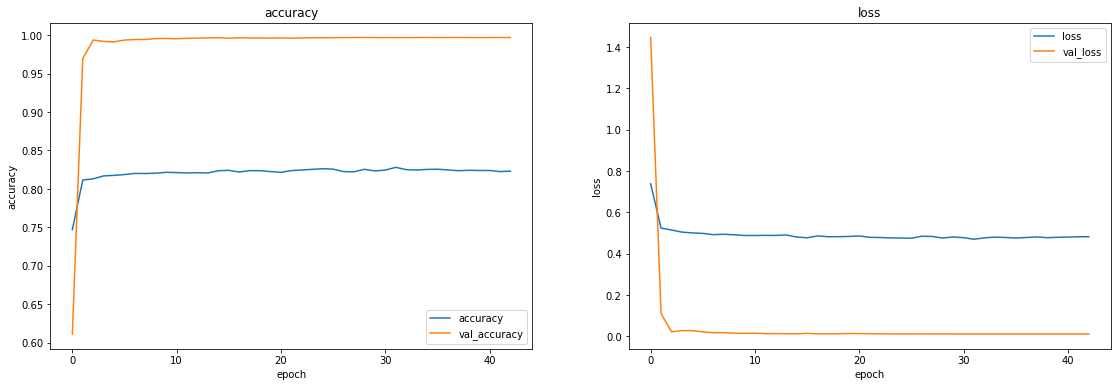

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(19, 6))

    # 精度の履歴をプロット
    plt.subplot(1, 2, 1)
    plt.title('accuracy')
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
 
    # 損失の履歴をプロット
    plt.subplot(1, 2, 2)
    plt.title('loss')
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
plot_history(history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


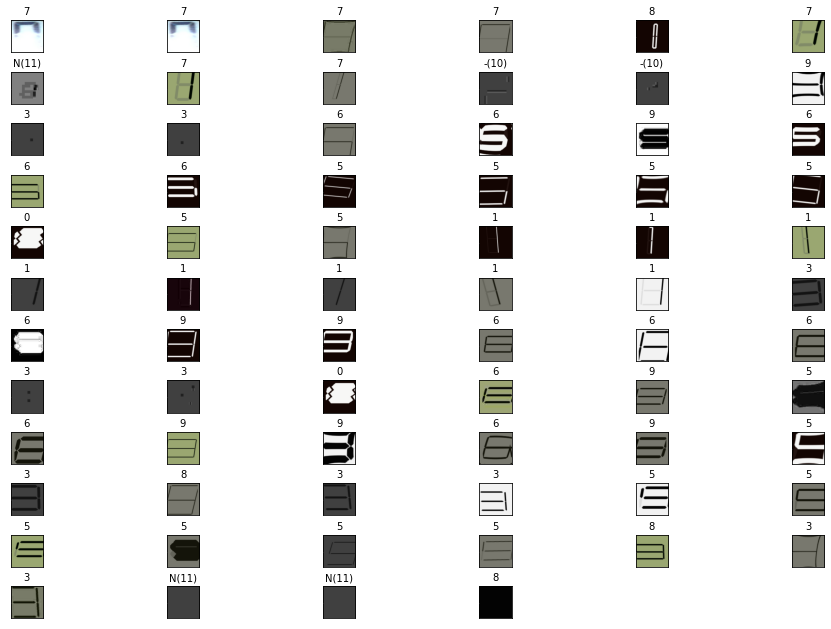

In [17]:
import math
import cv2 as cv
import numpy as np

def draw_images(images):
    column = 6
    row = math.ceil(len(images) / column)

    plt.figure(figsize=(16, 11))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    for i, image in enumerate(images):
        debug_image = cv.imread(image[1])
        
        plt.subplot(row, column, i+1)
        plt.title(str(image[0]), fontsize=10) 
        plt.tick_params(color='white')
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.imshow(cv.cvtColor(debug_image, cv.COLOR_BGR2RGB))
        plt.xlabel('', fontsize=15)
        plt.ylabel('', rotation=0, fontsize=15, labelpad=20)

    plt.show()

Y_pred = model.predict_generator(validation_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

incorrect_numbers = []
for true_num, pred_num, filepath in zip(validation_data_gen.classes, y_pred, validation_data_gen.filepaths):
    if true_num != pred_num:
        if pred_num == 10:
            incorrect_numbers.append(['-(10)', filepath])
        elif pred_num == 11:
            incorrect_numbers.append(['N(11)', filepath])
        else:
            incorrect_numbers.append([pred_num, filepath])

draw_images(incorrect_numbers)

# XXXXXXXX

In [18]:
model_path = 'checkpoints/weights.hdf5'
load_model = tf.keras.models.load_model(model_path)

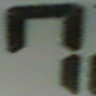

In [19]:
from IPython.display import Image, display_png
from tensorflow.keras.preprocessing.image import img_to_array, load_img

test_image = tf.keras.preprocessing.image.load_img('./validation/07/00007004.jpg', target_size=(96, 96))

display_png(test_image)

In [20]:
test_image = img_to_array(test_image)
test_image = test_image.reshape(-1, 96, 96, 3)
test_image = test_image.astype('float32')
test_image = test_image * 1.0/255

In [30]:
predict_result = load_model.predict(test_image)

10 loops, best of 5: 37.1 ms per loop


In [22]:
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.2122640e-06 6.4582217e-08 4.0999529e-07 7.6501377e-10 1.3395091e-07
 1.1328411e-06 2.9578780e-08 9.9999595e-01 2.8156240e-09 2.3762277e-08
 1.2261952e-08 6.3104553e-09]
7


# XXXXXXXX

In [23]:
load_model.save('7seg_classifier.hdf5', include_optimizer=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open('7seg_classifier.tflite', 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpl9niaoo4/assets


609904

# XXXXXXXX

In [25]:
interpreter = tf.lite.Interpreter(model_path="7seg_classifier.tflite")
interpreter.allocate_tensors()

In [26]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 96, 96,  3], dtype=int32), 'shape_signature': array([-1, 96, 96,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 177, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [31]:
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()

100 loops, best of 5: 18.6 ms per loop


In [28]:
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [29]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.3053269e-06 5.3328641e-08 4.0264879e-07 8.3536766e-10 1.3598803e-07
 1.3750700e-06 3.1720809e-08 9.9999571e-01 2.5853140e-09 2.5920599e-08
 9.1866488e-09 5.2289262e-09]
7
